# Классификация табличных данных

##### Автор: Виктор Китов ([DeepMachineLearning.ru](https://deepmachinelearning.ru))

##### Лицензия: BSD-3-Clause

В этом ноутбуке мы изучим В этом ноутбуке мы изучим задачу **классификации посетителей сайта**, используя данные веб-аналитики. Целевая переменная — бинарная: совершил ли посетитель покупку (`Revenue`).

## Данные

- **Числовые признаки:** BounceRates, ExitRates, PageValues, SpecialDay, Administrative_Duration, ProductRelated, ProductRelated_Duration, Informational, Informational_Duration, Administrative  
- **Категориальные признаки:** Browser, OperatingSystems, VisitorType, Month, Region, TrafficType, Weekend

## План

1. Предобработаем признаки: числовые признаки будут приведены к одному масштабу через RobustScaler, а для категориальных признаков сравним кодирование через OneHotEncoder MeanValueEncoder.
2. Подберём наилучшие гиперпараметры для моделей: kNN, SVM с RBF ядром, логистическая регрессия, случайный лес и градиентный бустинг.
3. Сравним модели по ROC-AUC на кросс-валидации по обучающей выборке и на тестовой выборке.
4. Приведём детальный отчёт качества работы лучшей модели
5. Проанализируем лучшую модель на качественном уровне - оценим признаки, вносящие наибольший вклад в прогноз, а также построим зависимость целевой величины от признаков.

In [1]:
import numpy as np
import pandas as pd
import openml
import warnings
from collections import OrderedDict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# Отключение предупреждений
warnings.filterwarnings("ignore")

In [3]:
# Глобальная переменная для кросс-валидации
FOLDS = 3

In [4]:
# Загрузка данных
dataset = openml.datasets.get_dataset(45060)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
y = y.astype(int)

In [5]:
# Проверим, нет ли в данных пропусков
print("Проверка пропусков:")

# Пропуски в признаках
missing_X = X.isnull().sum()
n_missing_X = missing_X.sum()

# Пропуски в целевой переменной
n_missing_y = y.isnull().sum()

print(f"Пропуски в X: {n_missing_X}")
print(f"Пропуски в y: {n_missing_y}")


if n_missing_X==0 and n_missing_y:
    print("Пропуски отсутствуют.\n")

Проверка пропусков:
Пропуски в X: 0
Пропуски в y: 0


### Ранее мы уже анализировали эти данные, поэтому сразу разобъём признаки на вещественные и категориальные

In [6]:
# Разобъём признаки на категориальные и вещественные
CAT_COLS = ['Browser', 'OperatingSystems', 'VisitorType', 'Month', 'Region', 'TrafficType', 'Weekend']
NUM_COLS = ['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Administrative_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'Informational', 'Informational_Duration', 'Administrative']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# OneHotEncoder-кодирование для категориальных признаков

## Подберём гиперпараметры моделей по кросс-валидации на обучении

In [7]:
# Препроцессор: RobustScaler для чисел и OneHot для категорий
scaler_ohe = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUM_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_COLS)
    ])

In [8]:
def evaluate_model(name, model, preprocessor, params):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Поиск по сетке на обучающей выборке
    grid = GridSearchCV(
        pipe,
        params,
        cv=FOLDS,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    # Печать названия модели, лучшей ROC-AUC по кросс-валидации
    # и лучших параметров, разделённых чертой и выровненных по ширине
    print(
        f"{name:<25} | "
        f"Best CV ROC-AUC: {grid.best_score_:<8.4f} | "
        f"Best params: {grid.best_params_}"
    )
    
    return grid.best_estimator_

In [9]:
def evaluate_on_test(models_dict, X_test, y_test):
    """
    Оценивает обученные модели на тестовой выборке по ROC-AUC
    и печатает аккуратно отформатированную таблицу.
    """
    print("-" * 45)
    print(f"{'Модель':<25} | {'Test ROC-AUC':<12}")
    print("-" * 45)

    for name, model in models_dict.items():
        # Предсказания вероятностей положительного класса
        y_score = model.predict_proba(X_test)[:, 1]

        # Расчёт ROC-AUC на тестовой выборке
        test_score = roc_auc_score(y_test, y_score)

        print(f"{name:<25} | {test_score:.4f}")

In [10]:
# Словарь для хранения лучших обученных моделей
best_models_ohe = OrderedDict()

print('Лучшие конфигурации моделей по кросс-валидации на train:')

# Метод ближайших соседей (kNN)
best_models_ohe["kNN-ohe"] = evaluate_model(
    "kNN", 
    KNeighborsClassifier(), scaler_ohe,
    {'model__n_neighbors': [3, 5, 7, 11, 15, 21, 51, 101, 131]}
)

# Метод опорных векторов (SVM)
best_models_ohe["SVM-RBF-ohe"] = evaluate_model(
    "SVM", 
    SVC(kernel='rbf', probability=True, random_state=42), scaler_ohe,
    {'model__gamma': [0.01, 0.05, 0.1, 'scale', 'auto'],'model__C':[1e-1,1,10]}
)

# Логистическая регрессия
best_models_ohe["LogReg-ohe"] = evaluate_model(
    "Logistic Regression", 
    LogisticRegression(solver='saga', max_iter=5000, random_state=42), scaler_ohe,
    {'model__C': [0.01, 0.1, 1, 10, 100]}
)

# Random Forest
best_models_ohe["RandomForest-ohe"] = evaluate_model(
    "Random Forest", 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42), scaler_ohe,
    {'model__max_features': [0.1, 0.3, 0.5, 0.7, 0.9]}
)

# Gradient Boosting
best_models_ohe["Boosting-ohe"] = evaluate_model(
    "Gradient Boosting", 
    GradientBoostingClassifier(
        learning_rate=0.1, 
        n_estimators=500, 
        n_iter_no_change=10, 
        validation_fraction=0.1, 
        random_state=42
    ), scaler_ohe,
    {
        'model__criterion': ['friedman_mse', 'squared_error'],
        'model__max_depth': [3, 5, 8]
    }
)


Лучшие конфигурации моделей по кросс-валидации на train:
kNN                       | Best CV ROC-AUC: 0.9037   | Best params: {'model__n_neighbors': 101}
SVM                       | Best CV ROC-AUC: 0.8973   | Best params: {'model__C': 1, 'model__gamma': 0.05}
Logistic Regression       | Best CV ROC-AUC: 0.8812   | Best params: {'model__C': 100}
Random Forest             | Best CV ROC-AUC: 0.9313   | Best params: {'model__max_features': 0.3}
Gradient Boosting         | Best CV ROC-AUC: 0.9305   | Best params: {'model__criterion': 'friedman_mse', 'model__max_depth': 3}


## Сравним качество моделей на тесте

In [11]:
evaluate_on_test(best_models_ohe, X_test, y_test)

---------------------------------------------
Модель                    | Test ROC-AUC
---------------------------------------------
kNN-ohe                   | 0.9017
SVM-RBF-ohe               | 0.8917
LogReg-ohe                | 0.8733
RandomForest-ohe          | 0.9267
Boosting-ohe              | 0.9218


# MeanValue-кодирование категориальных признаков

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanValueEncoder(BaseEstimator, TransformerMixin):
    """
    Mean Value Encoder без CV.
    Преобразует категориальные колонки в среднее целевой переменной по каждой категории.
    """
    def __init__(self, cols=None):
        self.cols = cols
        self.global_mean_ = None
        self.encoders_ = {}

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        self.global_mean_ = float(y.mean())
        self.encoders_ = {}

        for col in self.cols:
            means = y.groupby(X[col]).mean()
            self.encoders_[col] = means.to_dict()

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.cols:
            X[col] = (
                X[col]
                .map(self.encoders_[col])
                .astype(float)                 
                .fillna(self.global_mean_)
            )

        return X[self.cols].to_numpy()  

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена признаков после преобразования."""
        # Если переданы имена входных признаков, используем их
        if input_features is not None:
            # Возвращаем только те колонки, которые были закодированы
            return np.array([col for col in input_features if col in self.cols])
        # Иначе возвращаем просто имена колонок
        return np.array(self.cols)        

In [13]:
# Препроцессор с Mean Value Encoding
scaler_mv = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), NUM_COLS),
        ('cat', MeanValueEncoder(cols=CAT_COLS), CAT_COLS)
    ],
    remainder='drop'
)

In [14]:
# Словарь для хранения лучших обученных моделей
best_models_mv = OrderedDict()

print('Лучшие конфигурации моделей по кросс-валидации на train:')

# Метод ближайших соседей (kNN)
best_models_mv["kNN-mv"] = evaluate_model(
    "kNN", 
    KNeighborsClassifier(), scaler_mv,
    {'model__n_neighbors': [3, 5, 7, 11, 15, 21, 51, 101, 131]}
)

# Метод опорных векторов (SVM)
best_models_mv["SVM-RBF-mv"] = evaluate_model(
    "SVM", 
    SVC(kernel='rbf', probability=True, random_state=42), scaler_mv,
    {'model__gamma': [0.01, 0.05, 0.1, 'scale', 'auto'],'model__C':[1e-1,1,10]}
)

# Логистическая регрессия
best_models_mv["LogReg-mv"] = evaluate_model(
    "Logistic Regression", 
    LogisticRegression(solver='saga', max_iter=5000, random_state=42), scaler_mv,
    {'model__C': [0.01, 0.1, 1, 10, 100]}
)

# Random Forest
best_models_mv["RandomForest-mv"] = evaluate_model(
    "Random Forest", 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42), scaler_mv,
    {'model__max_features': [0.1, 0.3, 0.5, 0.7, 0.9]}
)

# Gradient Boosting
best_models_mv["Boosting-mv"] = evaluate_model(
    "Gradient Boosting", 
    GradientBoostingClassifier(
        learning_rate=0.1, 
        n_estimators=500, 
        n_iter_no_change=10, 
        validation_fraction=0.1, 
        random_state=42
    ), scaler_mv,
    {
        'model__criterion': ['friedman_mse', 'squared_error'],
        'model__max_depth': [3, 5, 8]
    }
)


Лучшие конфигурации моделей по кросс-валидации на train:
kNN                       | Best CV ROC-AUC: 0.8963   | Best params: {'model__n_neighbors': 101}
SVM                       | Best CV ROC-AUC: 0.8659   | Best params: {'model__C': 0.1, 'model__gamma': 'auto'}
Logistic Regression       | Best CV ROC-AUC: 0.8231   | Best params: {'model__C': 100}
Random Forest             | Best CV ROC-AUC: 0.9326   | Best params: {'model__max_features': 0.3}
Gradient Boosting         | Best CV ROC-AUC: 0.9303   | Best params: {'model__criterion': 'squared_error', 'model__max_depth': 3}


## Сравним качество моделей на тесте

In [15]:
evaluate_on_test(best_models_mv, X_test, y_test)

---------------------------------------------
Модель                    | Test ROC-AUC
---------------------------------------------
kNN-mv                    | 0.8924
SVM-RBF-mv                | 0.8559
LogReg-mv                 | 0.8290
RandomForest-mv           | 0.9267
Boosting-mv               | 0.9285


In [25]:
model = best_models_ohe["RandomForest-ohe"]

# Детальнее изучим качество лучшей модели

In [38]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [40]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2084
           1       0.75      0.59      0.66       382

    accuracy                           0.91      2466
   macro avg       0.84      0.78      0.80      2466
weighted avg       0.90      0.91      0.90      2466



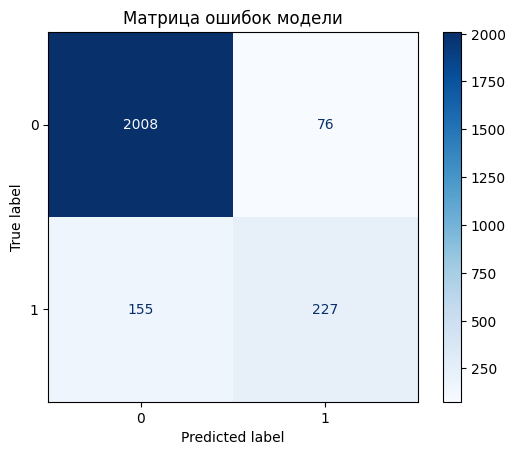

In [42]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=[0,1],  # 0 = нет покупки, 1 = покупка
    cmap=plt.cm.Blues,
    normalize=None  # можно поставить 'true' для нормализованной матрицы
)
plt.title("Матрица ошибок модели")
plt.show()

# Проанализируем лучшую модель

## Извлечём имена признаков

In [26]:
# Получаем препроцессор из pipeline
preprocessor = model.named_steps['preprocessor']

# Числовые признаки
num_features = NUM_COLS

# Категориальные признаки после OHE
cat_transformer = preprocessor.named_transformers_['cat']
ohe_features = cat_transformer.get_feature_names_out(CAT_COLS)

# Полный список признаков
feature_names = np.concatenate([num_features, ohe_features])
feature_names

array(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'Administrative_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'Informational',
       'Informational_Duration', 'Administrative', 'Browser_1',
       'Browser_10', 'Browser_11', 'Browser_12', 'Browser_13',
       'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6',
       'Browser_7', 'Browser_8', 'Browser_9', 'OperatingSystems_1',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'OperatingSystems_5', 'OperatingSystems_6', 'OperatingSystems_7',
       'OperatingSystems_8', 'VisitorType_New_Visitor',
       'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Region_1',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Region_8', 'Region_9', 'TrafficType_1',
       'TrafficType_

## Отобразим признаки в порядке убывания важности

#### Используем важность Mean Decrease in Impority

In [27]:
rf_model = best_models_ohe["RandomForest-ohe"].named_steps['model']

importances = rf_model.feature_importances_

feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_importances.head(20))  # топ-20 признаков

                          feature  importance
2                      PageValues    0.518441
1                       ExitRates    0.073640
6         ProductRelated_Duration    0.069881
5                  ProductRelated    0.060973
0                     BounceRates    0.052533
4         Administrative_Duration    0.041078
9                  Administrative    0.032405
41                      Month_Nov    0.031408
8          Informational_Duration    0.016456
7                   Informational    0.008481
33  VisitorType_Returning_Visitor    0.007764
31        VisitorType_New_Visitor    0.006962
64                  TrafficType_2    0.006309
44                       Region_1    0.005653
40                      Month_May    0.005402
24             OperatingSystems_2    0.004437
74                   Weekend_True    0.004227
15                      Browser_2    0.004187
73                  Weekend_False    0.003991
35                      Month_Dec    0.003818


#### Используем важность Permutation Feature Importance

In [44]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Ссылка на модель
model = best_models_ohe["RandomForest-ohe"]

# Трансформируем X_test через препроцессор
X_test_trans = model.named_steps['preprocessor'].transform(X_test)

# Получаем имена признаков после препроцессинга
num_features = NUM_COLS
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(CAT_COLS)
feature_names = list(num_features) + list(cat_features)

# Расчет permutation importance
result = permutation_importance(
    model.named_steps['model'],  # уже RandomForest
    X_test_trans,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Преобразуем в DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Сортировка по убыванию
importance_df = importance_df.sort_values(by='importance_mean', ascending=False)

# Вывод
print(importance_df.head(20))



                          feature  importance_mean  importance_std
2                      PageValues         0.296966        0.007764
41                      Month_Nov         0.028220        0.002562
9                  Administrative         0.007653        0.001546
4         Administrative_Duration         0.005067        0.001174
6         ProductRelated_Duration         0.004225        0.001988
5                  ProductRelated         0.004054        0.001357
1                       ExitRates         0.003714        0.001332
0                     BounceRates         0.002314        0.001249
43                      Month_Sep         0.002030        0.000176
40                      Month_May         0.001969        0.000898
39                      Month_Mar         0.001403        0.000337
37                      Month_Jul         0.000820        0.000464
31        VisitorType_New_Visitor         0.000624        0.000666
33  VisitorType_Returning_Visitor         0.000598        0.00

## Построим зависимость прогноза p(y=1|x) от признака

In [28]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

### Зависимость от `PageValues`

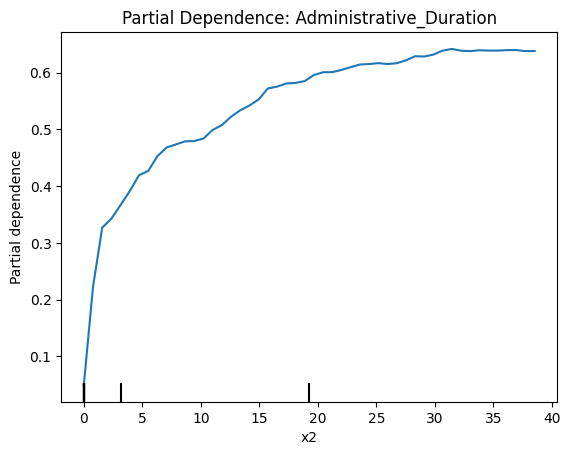

In [37]:
# Ссылка на модель
model = best_models_ohe["RandomForest-ohe"]

# Преобразуем X_train через препроцессор pipeline
X_train_trans = model.named_steps['preprocessor'].transform(X_train)

# Индекс признака 'Administrative_Duration' в числовых колонках
feature_idx = NUM_COLS.index('PageValues')

# Генерируем PDP
PartialDependenceDisplay.from_estimator(
    model.named_steps['model'],  # уже чистый RandomForest
    X_train_trans,
    features=[feature_idx],
    grid_resolution=50
)

plt.title('Partial Dependence: Administrative_Duration')
plt.show()

### Зависимость от `Administrative_Duration`

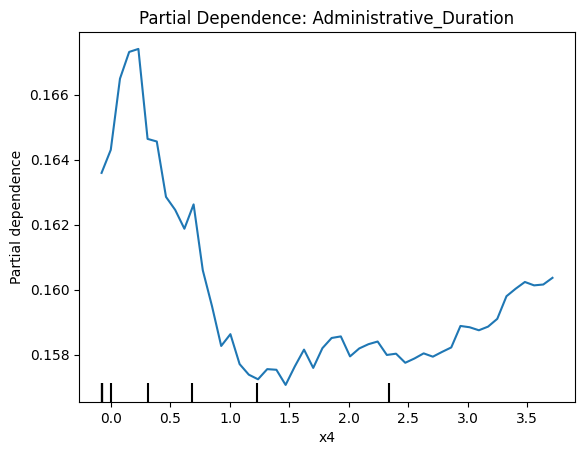

In [36]:
# Ссылка на модель
model = best_models_ohe["RandomForest-ohe"]

# Преобразуем X_train через препроцессор pipeline
X_train_trans = model.named_steps['preprocessor'].transform(X_train)

# Индекс признака 'Administrative_Duration' в числовых колонках
feature_idx = NUM_COLS.index('Administrative_Duration')

# Генерируем PDP
PartialDependenceDisplay.from_estimator(
    model.named_steps['model'],  # уже чистый RandomForest
    X_train_trans,
    features=[feature_idx],
    grid_resolution=50
)

plt.title('Partial Dependence: Administrative_Duration')
plt.show()


# Генерация дополнительных признаков